In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.init as init
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import RectBivariateSpline
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import scipy.io
from scipy.io import loadmat
import math
from PIL import Image
from scipy.ndimage import zoom
import matplotlib
from scipy.interpolate import interp2d
import time
import cv2
from scipy.ndimage import uniform_filter
from scipy.ndimage import gaussian_filter

In [5]:
np.random.seed(2345)
torch.manual_seed(1234)
# CUDA
# if gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available")
else:
    device = torch.device('cpu')
    print("Only cpu is available")
    
torch.backends.cudnn.benchmark = True
epsilon = torch.finfo(torch.float32).eps


class DNN1(torch.nn.Module):
    def __init__(self, width):
        super(DNN1, self).__init__()
        self.width = width
        self.p = nn.Conv2d(2, self.width, 1)
        self.mlp1 = nn.Conv2d(self.width, self.width, 1) # 不缩放
        self.dropout1 = nn.Dropout(0.1)  # 50% 的 Dropout
        self.mlp2 = nn.Conv2d(self.width, self.width, 1)
        self.dropout2 = nn.Dropout(0.1)
        self.mlp3 = nn.Conv2d(self.width, self.width, 1) # 不缩放
        self.dropout3 = nn.Dropout(0.1)
        self.mlp4 = nn.Conv2d(self.width, self.width, 1)
        self.dropout4 = nn.Dropout(0.1)
        self.q = nn.Conv2d(self.width, 2, 1)
        self.norm = nn.InstanceNorm2d(self.width)
        self.a = nn.Parameter(torch.tensor(0.2))
        
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.p(x)
        x = 5 * self.a * x
        x = torch.tanh(x)
        
        x = self.mlp1(x)
        x = 5 * self.a * x
        x = torch.tanh(x)
        x = self.dropout1(x)
        
        x = self.mlp2(x)
        x = 5 * self.a * x
        x = torch.tanh(x)
        x = self.dropout2(x)
        
        x = self.mlp3(x)
        x = 5 * self.a * x
        x = torch.tanh(x)
        x = self.dropout3(x)
        
        x = self.mlp4(x)
        x = 5 * self.a * x
        x = torch.tanh(x)
        x = self.dropout4(x)
        
        x = self.q(x)
        return x 

class PhysicsInformedNN1:
    def __init__(self, ref_gray_matrix, def_gray_matrix, ROI, width, IX, IY):
        
        self.Iref = torch.tensor(ref_gray_matrix, dtype=torch.float32).to(device)
        self.Idef = torch.tensor(def_gray_matrix, dtype=torch.float32).to(device)
        self.roi = torch.tensor(ROI, dtype=torch.float32).to(device)
        self.ROI = ROI
        self.IX = torch.tensor(IX, dtype=torch.float32).to(device)
        self.IY = torch.tensor(IY, dtype=torch.float32).to(device)
        self.XY = torch.stack((self.IX, self.IY), dim=2).unsqueeze(0)
        
        self.width = width
        
        # 加载深度学习网络
        self.dnn = DNN1(self.width).to(device)
        
        self.epoch = 0
        self.loss_list = []
        self.lossf_list = []
        
        # 设置优化器
        self.optimizer = torch.optim.LBFGS(self.dnn.parameters(), lr=1, max_iter=2000, max_eval=50000,
                                           history_size=50, tolerance_grad=1e-08, tolerance_change=0.5 * np.finfo(float).eps,
                                           line_search_fn="strong_wolfe")
        
        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=0.001,  eps=1e-8, weight_decay=0.0001)
        self.scheduler = lr_scheduler.CosineAnnealingLR(self.optimizer_adam, T_max=50)  # T_max 可以根据需要调整

    def net_f(self, UV):
        target_height = self.Idef.shape[0]
        target_width = self.Idef.shape[1]
        upscaled_displacement_field = UV
        # u = upscaled_displacement_field[0,0]/self.Idef.shape[1]  # 缩放
        # v = upscaled_displacement_field[0,1]/self.Idef.shape[0]  # 缩放
        u = upscaled_displacement_field[0,0]
        v = upscaled_displacement_field[0,1]
        # 计算 ex, ey, exy
        ex = torch.diff(u, dim=0)[:,1:target_width+1]  # 在行维度上计算向前差分(255, 512)->(255, 511)
        ey = torch.diff(v, dim=1)[1:target_height+1,:]  # 在列维度上计算向前差分(256, 511)->(255, 511)
        exy = 0.5 * (ex + ey)
        # 计算 ex1, ex2, ey1, ey2, exy1, exy2
        ex1 = torch.diff(ex, dim=0)
        ex2 = torch.diff(ex1, dim=0)[:,2:target_width] # Epsilon x 的二阶导(253, 511)->(253, 509)
        ey1 = torch.diff(ey, dim=1)
        ey2 = torch.diff(ey1, dim=1)[2:target_height,:] # Epsilon y 的二阶导(255, 509)->(253, 509)
        exy1 = torch.diff(exy, dim=0)
        exy2 = torch.diff(exy1, dim=1)[1:target_height-1, 1:target_width-1] # Epsilon xy 的二阶导 (254, 510)->(253, 509)
        result = torch.sum((ex2 + ey2 - exy2) ** 2)
        return result
    
    def loss_fn1(self):
        self.optimizer.zero_grad()
        UV = self.dnn(self.XY)
        loss_f = self.net_f(UV)
        
        target_height = self.Idef.shape[0]
        target_width = self.Idef.shape[1]
        
        upscaled_displacement_field = UV
        u = upscaled_displacement_field[0,0]/self.Idef.shape[1] * self.roi
        v = upscaled_displacement_field[0,1]/self.Idef.shape[0] * self.roi
        uv_displacement = torch.stack((u, v), dim=2).unsqueeze(0)
        
        X_new = self.XY + uv_displacement
        
        # 插值新的散斑图: 理论仿真实验用 bilinear ，实际实验用 bicubic
        new_Idef = F.grid_sample(self.Iref.view(1, 1, self.Iref.shape[0], self.Iref.shape[1]), 
                                 X_new.view(1, self.Idef.shape[0], self.Idef.shape[1], 2), 
                                 mode='bilinear', align_corners=True)
        
        # 计算两张图的相关数
        abs_error = (new_Idef[0, 0] - self.Idef)**2
        abs_error = torch.log(1+abs_error) * self.roi
        loss = 5 * torch.sum(abs_error)/(abs_error.shape[0]*abs_error.shape[1]) #+ loss_f*0.001
        # print('loss计算完毕')
        loss.backward()
        self.epoch = self.epoch+1
        # print('backward完毕')
        if self.epoch%100 == 1:
            # print(f"Epoch [{self.epoch}], Loss: {loss.item()}, Lossf: {loss_f.item()}")
            #displacement_field = upscaled_displacement_field[0,1]
            #self.save_displacement_image(displacement_field, self.epoch)
            self.loss_list.append(loss.item())
            self.lossf_list.append(loss_f.item())
        return loss

    def loss_fn2(self):
        self.optimizer.zero_grad()
        UV = self.dnn(self.XY)
        loss_f = self.net_f(UV)
        
        target_height = self.Idef.shape[0]
        target_width = self.Idef.shape[1]
        
        upscaled_displacement_field = UV
        u = upscaled_displacement_field[0,0]/self.Idef.shape[1] * self.roi
        v = upscaled_displacement_field[0,1]/self.Idef.shape[0] * self.roi
        uv_displacement = torch.stack((u, v), dim=2).unsqueeze(0)
        
        X_new = self.XY + uv_displacement
        
        # 插值新的散斑图: 理论仿真实验用 bilinear ，实际实验用 bicubic
        new_Idef = F.grid_sample(self.Iref.view(1, 1, self.Iref.shape[0], self.Iref.shape[1]), 
                                 X_new.view(1, self.Idef.shape[0], self.Idef.shape[1], 2), 
                                 mode='bilinear', align_corners=True)
        # print('新散斑图像插值完毕')
        
        # 计算两张图的相关数
        abs_error = (new_Idef[0, 0] - self.Idef)**2 * self.roi
        # abs_error = torch.log(1+abs_error)
        loss = torch.sum(abs_error)/(abs_error.shape[0]*abs_error.shape[1]) #+ loss_f*0.001
        # print('loss计算完毕')
        loss.backward()
        self.epoch = self.epoch+1
        # print('backward完毕')
        if self.epoch%100 == 1:   
            # print(f"Epoch [{self.epoch}], Loss: {loss.item()}, Lossf: {loss_f.item()}")
            #displacement_field = upscaled_displacement_field[0,1]
            #self.save_displacement_image(displacement_field, self.epoch)
            self.loss_list.append(loss.item())
            self.lossf_list.append(loss_f.item())
        return loss
         
    def train(self, flag):
        self.dnn.train()
        if flag==1:
            self.optimizer.step(self.loss_fn1)
        else:
            self.optimizer.step(self.loss_fn2)          
    
    def train_adam(self, flag, epoch):
        self.dnn.train()
        if flag==1:
            for iter in range(epoch):
                loss = self.loss_fn1()
                self.optimizer_adam.step()
                self.scheduler.step()
        else:
            for iter in range(epoch):
                loss = self.loss_fn2()
                self.optimizer_adam.step()
                self.scheduler.step()
    
    def predict(self, X, Y):
        self.dnn.eval()
        
        Ixy = np.stack((X, Y), axis=-1)
        Ixy = torch.tensor(Ixy, dtype=torch.float32).unsqueeze(0).to(device)
        U = self.dnn(Ixy)
        u = U[:,0]
        u = u.cpu().detach().numpy()
        v = U[:,1]
        v = v.cpu().detach().numpy()
        return u, v
        

CUDA is available


In [7]:
def DIC_Strain_from_Displacement(u, v, flag, step, SmoothLen):
    u = u.T
    v = v.T
    flag = flag.T

    m = SmoothLen
    if m % 2 == 0:  # 判断m是不是奇数
        m += 1  # m必须为奇数
    hfm = (m - 1) // 2

    # 扩展矩阵
    uc = np.full((u.shape[0] + 2*hfm, u.shape[1] + 2*hfm), np.nan)
    vc = np.full((v.shape[0] + 2*hfm, v.shape[1] + 2*hfm), np.nan)
    flag_c = np.zeros((flag.shape[0] + 2*hfm, flag.shape[1] + 2*hfm))
    ny, nx = uc.shape
    
    uc[hfm:ny-hfm, hfm:nx-hfm] = u
    vc[hfm:ny-hfm, hfm:nx-hfm] = v
    
    # print(len(range(hfm,ny-hfm)))
    flag_c[hfm:ny-hfm, hfm:nx-hfm] = flag

    Ex = np.full(u.shape, np.nan)
    Ey = np.full(u.shape, np.nan)
    Exy = np.full(u.shape, np.nan)

    for i in range(nx - 2*m):
        for j in range(ny - 2*m):
            if flag[j, i] == 0:
                continue

            # print(f"i:{i}, j:{j}")
            startx = i
            starty = j

            stopx = startx + m
            stopy = starty + m

            uu = u[starty:stopy, startx:stopx]
            vv = v[starty:stopy, startx:stopx]
            FLAG = flag[starty:stopy, startx:stopx]
            X, Y = np.meshgrid(np.arange(-hfm, hfm+1), np.arange(-hfm, hfm+1))
            xx = X * step
            yy = Y * step

            X = np.column_stack((np.ones(m**2), yy.flatten(), xx.flatten()))

            f_valid = np.where(FLAG.flatten() == 1)[0]
            # print(f"f_valid.shape:{f_valid.shape}")

            if len(f_valid) > 0:
                if np.sum(FLAG) > 3:
                    f_invalid = np.where(FLAG.flatten() == 0)[0]
                    U = uu.flatten()[f_valid]
                    V = vv.flatten()[f_valid]
                    X = np.delete(X, f_invalid, axis=0)
                    U = np.delete(U, f_invalid)
                    V = np.delete(V, f_invalid)

                    # print(f"X.shape: {X.shape}, U.shape: {U.shape}, V.shape: {V.shape}")
                    a = np.linalg.lstsq(X, U, rcond=None)[0]
                    b = np.linalg.lstsq(X, V, rcond=None)[0]
                else:
                    a = np.full(3, np.nan)
                    b = np.full(3, np.nan)
            else:
                a = np.full(3, np.nan)
                b = np.full(3, np.nan)

            Ex[j, i] = a[1]
            Ey[j, i] = b[2]
            Exy[j, i] = (a[2] + b[1]) / 2

    return Ex.T, Ey.T, Exy.T

Text(0.5, 1.0, 'Deformed Image')

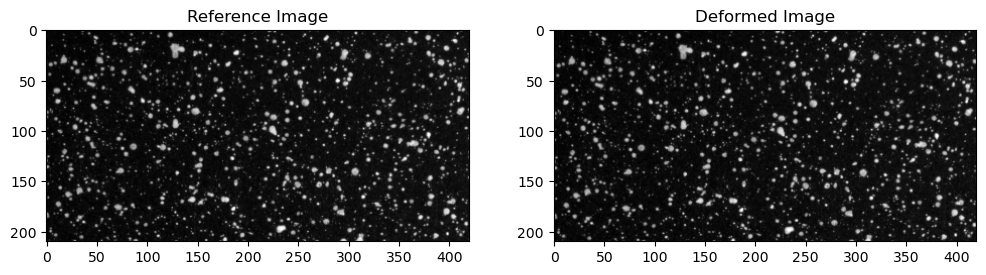

In [4]:
ref_image = Image.open('./speckle image/000.bmp')
ref_gray = ref_image.convert('L')
ref_gray = np.array(ref_gray)
RG = ref_gray[290:500,530:950]

def_image = Image.open('./speckle image/014.bmp')
def_gray = def_image.convert('L')
def_gray = np.array(def_gray)
DG = def_gray[290:500,530:950]

xstart_index = 5
ystart_index = 5
yend_index = DG.shape[0] - 5
xend_index = DG.shape[1] - 5

ROI = np.zeros_like(DG)
ROI[ystart_index:yend_index, xstart_index:xend_index] = 1


# sigma = 1.0  # 高斯核的标准差，可以根据需要调整
# RG = gaussian_filter(RG, sigma=sigma)
# DG = gaussian_filter(DG, sigma=sigma)

# # 绘制原始图像和插值后的图像
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.imshow(RG, cmap='gray')
plt.title('Reference Image')
plt.subplot(1, 2, 2)
plt.imshow(DG, cmap='gray')
plt.title('Deformed Image')


In [13]:
y_size, x_size = RG.shape
x_list = np.linspace(-1, 1, x_size)
y_list = np.linspace(-1, 1, y_size)
IX, IY = np.meshgrid(x_list, y_list)
# 网络结构
width = 50
model = PhysicsInformedNN1(RG, DG, ROI, width, IX, IY)
model.train_adam(1, 1000)
model.train_adam(2, 1200)

u,v = model.predict(IX, IY)
u = -u[0]/2*1.2
v = -v[0]/2*1.01

u_sub = u[ystart_index:yend_index, xstart_index:xend_index]
v_sub = v[ystart_index:yend_index, xstart_index:xend_index]

In [14]:
flag_P = np.ones_like(u_sub)
step = 1
SmoothLen_P = 15
Exx_P, Eyy_P, Exy_P = DIC_Strain_from_Displacement(u_sub, v_sub, flag_P, step, SmoothLen_P)
# filepath = 'uu_crack_003_02.mat'
# dic_data = loadmat(filepath)
# u_dic = dic_data['u']
# v_dic = dic_data['v']
# flag_S = np.ones_like(u_dic)
# SmoothLen_S = 19
# Exx_S, Eyy_S, Exy_S = DIC_Strain_from_Displacement(u_dic, v_dic, flag_S, step, SmoothLen_S)

(-0.5, 409.5, 199.5, -0.5)

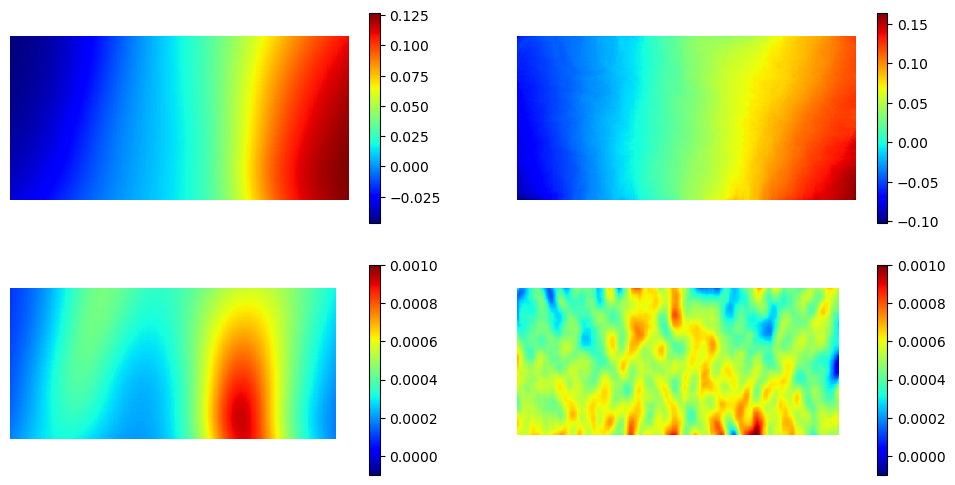

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(u_sub, cmap='jet', interpolation='nearest') # , norm=normu
plt.colorbar()
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(u_dic, cmap='jet', interpolation='nearest') # , norm=normv
plt.colorbar()
plt.axis('off')
plt.subplot(2, 2, 3)
normu = matplotlib.colors.Normalize(vmin=-0.0001, vmax=0.001)
plt.imshow(Exx_P, cmap='jet', interpolation='nearest', norm=normu) # , norm=normu
plt.colorbar()
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(Exx_S, cmap='jet', interpolation='nearest', norm=normu) # , norm=normv
plt.colorbar()
plt.axis('off')

In [18]:
data_to_save = {'exx_pinn': Exx_P, 'exx_sub': Exx_S,
                'u_sub': u_sub}
scipy.io.savemat(f'crack_003_b.mat', data_to_save)

(200, 410)

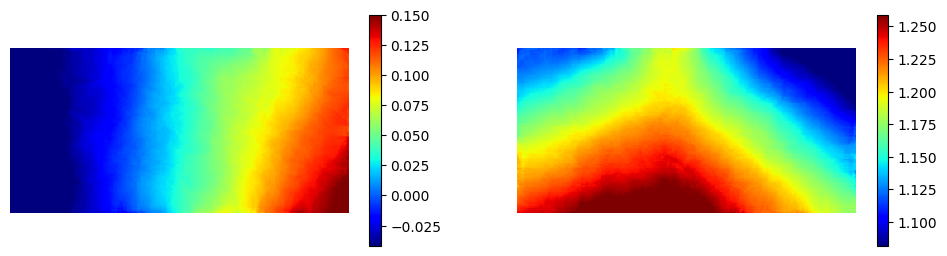

In [29]:


## 位移云图
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.imshow(u_dic, cmap='jet', interpolation='nearest', norm=normu) # , norm=normu
plt.colorbar()
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(v_dic, cmap='jet', interpolation='nearest', norm=normv) # , norm=normv
plt.colorbar()
plt.axis('off')



(-1.0, 1.0, -1.0, 1.0)

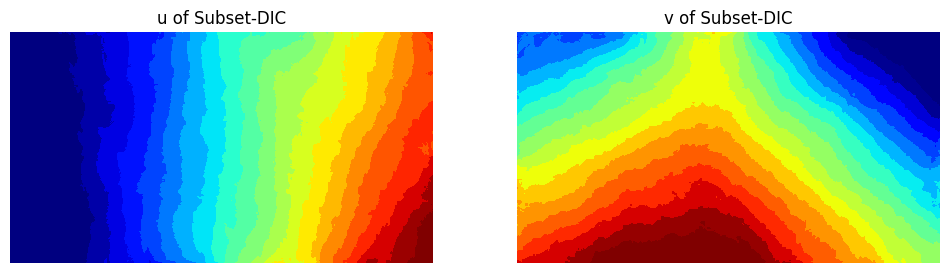

In [30]:
data_to_save = {'u_PINN': u_sub, 'v_PINN': v_sub,
                'u_subset': u_dic, 'v_subset': v_dic}
scipy.io.savemat(f'crack_003_a.mat', data_to_save)

In [18]:
# torch.save(model.dnn.state_dict(), r'D:\Jupyter\PINN in DIC\model parameters\crack_006_w50.pth')

In [9]:
print(uc)

[[nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan  1.  1.  1.  1. nan nan nan]
 [nan nan nan  1.  1.  1.  1. nan nan nan]
 [nan nan nan  1.  1.  1.  1. nan nan nan]
 [nan nan nan  1.  1.  1.  1. nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]]


In [8]:
u = np.ones((4,4))
hfm = 3
uc = np.full((u.shape[0] + 2*hfm, u.shape[1] + 2*hfm), np.nan)
ny, nx = uc.shape
uc[hfm:ny-hfm, hfm:nx-hfm] = u